### Hyperparameters:
| Hyperparameter       | Value   |
|----------------------|---------|
| num-filters          | 32      |
| num-bilstm-layer     | 2       |
| output-lstm-dim      | 64      |
| decay-rate           | 0.8     |
| learning-rate        | 0.01    |
| miniBatchSize        | 256     |
| filter-size          | 10 × 1  |
| input-lstm-dim       | 100     |
| L2Regularization     | 0.001   |
| optimizer            | Adam    |
| dropout              | 0.25    |
| maxEpochs            | 500     |

In [35]:
import sys
sys.path.append("..")

In [36]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [37]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

In [38]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

## CNN-BiLSTM

In [39]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [40]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [41]:
model = CNNBiLSTM(input_dim=len(features))

In [42]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [43]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [44]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 192261
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 231.30it/s]


Epoch [1/500] - Train Loss: 1.154961, Val Loss: 20.402533
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.02it/s]


Epoch [2/500] - Train Loss: 0.956292, Val Loss: 18.185198
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.95it/s]


Epoch [3/500] - Train Loss: 0.724879, Val Loss: 14.913905
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 283.21it/s]


Epoch [4/500] - Train Loss: 0.548627, Val Loss: 10.874963
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 227.22it/s]


Epoch [5/500] - Train Loss: 0.343371, Val Loss: 5.676986
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 322.83it/s]


Epoch [6/500] - Train Loss: 0.162026, Val Loss: 2.554083
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 289.81it/s]


Epoch [7/500] - Train Loss: 0.078457, Val Loss: 1.121899
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 241.32it/s]


Epoch [8/500] - Train Loss: 0.047554, Val Loss: 0.417685
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 320.82it/s]


Epoch [9/500] - Train Loss: 0.030367, Val Loss: 0.316915
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 56.67it/s]


Epoch [10/500] - Train Loss: 0.022168, Val Loss: 0.353074
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 137.20it/s]


Epoch [11/500] - Train Loss: 0.026902, Val Loss: 0.271609
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 238.81it/s]


Epoch [12/500] - Train Loss: 0.078264, Val Loss: 1.016786
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.32it/s]


Epoch [13/500] - Train Loss: 0.144454, Val Loss: 0.770559
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.27it/s]


Epoch [14/500] - Train Loss: 0.054788, Val Loss: 1.045069
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 302.34it/s]


Epoch [15/500] - Train Loss: 0.023148, Val Loss: 0.433253
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 287.32it/s]


Epoch [16/500] - Train Loss: 0.028119, Val Loss: 0.357002
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.33it/s]


Epoch [17/500] - Train Loss: 0.020362, Val Loss: 0.512383
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 199.68it/s]


Epoch [18/500] - Train Loss: 0.016205, Val Loss: 0.467730
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.49it/s]


Epoch [19/500] - Train Loss: 0.015071, Val Loss: 0.402447
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.59it/s]


Epoch [20/500] - Train Loss: 0.013558, Val Loss: 0.520148
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.56it/s]


Epoch [21/500] - Train Loss: 0.012650, Val Loss: 0.443118
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 300.84it/s]


Epoch [22/500] - Train Loss: 0.011248, Val Loss: 0.579616
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.39it/s]


Epoch [23/500] - Train Loss: 0.011953, Val Loss: 0.448470
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 245.52it/s]


Epoch [24/500] - Train Loss: 0.014128, Val Loss: 0.803738
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 299.99it/s]


Epoch [25/500] - Train Loss: 0.021698, Val Loss: 0.318844
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 278.52it/s]


Epoch [26/500] - Train Loss: 0.042770, Val Loss: 1.263859
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 164.83it/s]


Epoch [27/500] - Train Loss: 0.050331, Val Loss: 0.236409
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 297.49it/s]


Epoch [28/500] - Train Loss: 0.036052, Val Loss: 1.237479
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.00it/s]


Epoch [29/500] - Train Loss: 0.016737, Val Loss: 0.354535
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 323.77it/s]


Epoch [30/500] - Train Loss: 0.011198, Val Loss: 0.599781
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 245.76it/s]


Epoch [31/500] - Train Loss: 0.010827, Val Loss: 0.602471
Epoch 32/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.93it/s]


Epoch [32/500] - Train Loss: 0.010185, Val Loss: 0.516580
Epoch 33/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.77it/s]


Epoch [33/500] - Train Loss: 0.009411, Val Loss: 0.710369
Epoch 34/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 307.26it/s]


Epoch [34/500] - Train Loss: 0.010820, Val Loss: 0.525910
Epoch 35/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.62it/s]


Epoch [35/500] - Train Loss: 0.010497, Val Loss: 0.863861
Epoch 36/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.33it/s]


Epoch [36/500] - Train Loss: 0.012355, Val Loss: 0.452455
Epoch 37/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.51it/s]


Epoch [37/500] - Train Loss: 0.014727, Val Loss: 0.977971
Epoch 38/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.59it/s]


Epoch [38/500] - Train Loss: 0.020005, Val Loss: 0.344831
Epoch 39/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.69it/s]


Epoch [39/500] - Train Loss: 0.029968, Val Loss: 1.270662
Epoch 40/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.56it/s]


Epoch [40/500] - Train Loss: 0.040878, Val Loss: 0.226524
Epoch 41/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.21it/s]


Epoch [41/500] - Train Loss: 0.043440, Val Loss: 1.456943
Epoch 42/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 297.66it/s]


Epoch [42/500] - Train Loss: 0.033709, Val Loss: 0.262890
Epoch 43/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 298.06it/s]


Epoch [43/500] - Train Loss: 0.017661, Val Loss: 1.062225
Epoch 44/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 295.52it/s]


Epoch [44/500] - Train Loss: 0.009977, Val Loss: 0.518152
Epoch 45/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 287.93it/s]


Epoch [45/500] - Train Loss: 0.007636, Val Loss: 0.657752
Epoch 46/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 256.38it/s]


Epoch [46/500] - Train Loss: 0.008051, Val Loss: 0.739001
Epoch 47/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 307.70it/s]


Epoch [47/500] - Train Loss: 0.007357, Val Loss: 0.593773
Epoch 48/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.07it/s]


Epoch [48/500] - Train Loss: 0.007980, Val Loss: 0.799627
Epoch 49/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.46it/s]


Epoch [49/500] - Train Loss: 0.008437, Val Loss: 0.554715
Epoch 50/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 314.03it/s]


Epoch [50/500] - Train Loss: 0.010813, Val Loss: 0.969382
Epoch 51/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.45it/s]


Epoch [51/500] - Train Loss: 0.012733, Val Loss: 0.424458
Epoch 52/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 290.07it/s]


Epoch [52/500] - Train Loss: 0.018014, Val Loss: 1.085750
Epoch 53/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 232.58it/s]


Epoch [53/500] - Train Loss: 0.022760, Val Loss: 0.273875
Epoch 54/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.71it/s]


Epoch [54/500] - Train Loss: 0.025768, Val Loss: 1.250671
Epoch 55/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 245.07it/s]


Epoch [55/500] - Train Loss: 0.026128, Val Loss: 0.282819
Epoch 56/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 296.92it/s]


Epoch [56/500] - Train Loss: 0.021752, Val Loss: 1.238160
Epoch 57/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 240.33it/s]


Epoch [57/500] - Train Loss: 0.013936, Val Loss: 0.352339
Epoch 58/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.69it/s]


Epoch [58/500] - Train Loss: 0.009040, Val Loss: 0.879435
Epoch 59/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 299.41it/s]


Epoch [59/500] - Train Loss: 0.006883, Val Loss: 0.591044
Epoch 60/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.46it/s]


Epoch [60/500] - Train Loss: 0.005391, Val Loss: 0.720720
Epoch 61/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.75it/s]


Epoch [61/500] - Train Loss: 0.005302, Val Loss: 0.678557
Epoch 62/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.55it/s]


Epoch [62/500] - Train Loss: 0.004890, Val Loss: 0.702735
Epoch 63/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.42it/s]


Epoch [63/500] - Train Loss: 0.005620, Val Loss: 0.687731
Epoch 64/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 310.76it/s]


Epoch [64/500] - Train Loss: 0.005437, Val Loss: 0.685690
Epoch 65/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.46it/s]


Epoch [65/500] - Train Loss: 0.005716, Val Loss: 0.569073
Epoch 66/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 300.76it/s]


Epoch [66/500] - Train Loss: 0.007708, Val Loss: 0.832593
Epoch 67/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 219.30it/s]


Epoch [67/500] - Train Loss: 0.011051, Val Loss: 0.383042
Epoch 68/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.64it/s]


Epoch [68/500] - Train Loss: 0.019705, Val Loss: 1.142626
Epoch 69/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 316.31it/s]


Epoch [69/500] - Train Loss: 0.031130, Val Loss: 0.201521
Epoch 70/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.78it/s]


Epoch [70/500] - Train Loss: 0.040622, Val Loss: 1.480066
Epoch 71/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 293.09it/s]


Epoch [71/500] - Train Loss: 0.045463, Val Loss: 0.224390
Epoch 72/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 197.96it/s]


Epoch [72/500] - Train Loss: 0.032787, Val Loss: 1.365093
Epoch 73/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 287.72it/s]


Epoch [73/500] - Train Loss: 0.017049, Val Loss: 0.293346
Epoch 74/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.68it/s]


Epoch [74/500] - Train Loss: 0.008377, Val Loss: 0.785089
Epoch 75/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.16it/s]


Epoch [75/500] - Train Loss: 0.006415, Val Loss: 0.663563
Epoch 76/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.73it/s]


Epoch [76/500] - Train Loss: 0.005936, Val Loss: 0.691081
Epoch 77/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 189.61it/s]


Epoch [77/500] - Train Loss: 0.005222, Val Loss: 0.765529
Epoch 78/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 294.91it/s]


Epoch [78/500] - Train Loss: 0.004800, Val Loss: 0.746035
Epoch 79/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 286.20it/s]


Epoch [79/500] - Train Loss: 0.005357, Val Loss: 0.719417
Epoch 80/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 297.44it/s]


Epoch [80/500] - Train Loss: 0.006007, Val Loss: 0.855943
Epoch 81/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 293.34it/s]


Epoch [81/500] - Train Loss: 0.006280, Val Loss: 0.580777
Epoch 82/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 293.77it/s]

Epoch [82/500] - Train Loss: 0.006948, Val Loss: 0.895061
Epoch 83/500
----------------------------------------



100%|██████████| 2/2 [00:00<00:00, 283.16it/s]


Epoch [83/500] - Train Loss: 0.007782, Val Loss: 0.494902
Epoch 84/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 130.07it/s]


Epoch [84/500] - Train Loss: 0.010596, Val Loss: 1.019446
Epoch 85/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 292.18it/s]


Epoch [85/500] - Train Loss: 0.012048, Val Loss: 0.386410
Epoch 86/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 265.40it/s]


Epoch [86/500] - Train Loss: 0.012963, Val Loss: 1.091457
Epoch 87/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.14it/s]


Epoch [87/500] - Train Loss: 0.013078, Val Loss: 0.350996
Epoch 88/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 320.37it/s]


Epoch [88/500] - Train Loss: 0.011888, Val Loss: 1.009730
Epoch 89/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.90it/s]


Epoch [89/500] - Train Loss: 0.010700, Val Loss: 0.392134
Epoch 90/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 310.14it/s]


Epoch [90/500] - Train Loss: 0.010339, Val Loss: 0.918636
Epoch 91/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 302.02it/s]


Epoch [91/500] - Train Loss: 0.009467, Val Loss: 0.380998
Epoch 92/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 291.25it/s]


Epoch [92/500] - Train Loss: 0.009312, Val Loss: 0.887965
Epoch 93/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 305.76it/s]


Epoch [93/500] - Train Loss: 0.008727, Val Loss: 0.406385
Epoch 94/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 235.32it/s]


Epoch [94/500] - Train Loss: 0.007790, Val Loss: 0.866719
Epoch 95/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.47it/s]


Epoch [95/500] - Train Loss: 0.007568, Val Loss: 0.424098
Epoch 96/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 158.86it/s]


Epoch [96/500] - Train Loss: 0.008594, Val Loss: 0.837180
Epoch 97/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 129.73it/s]


Epoch [97/500] - Train Loss: 0.008276, Val Loss: 0.392026
Epoch 98/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.01it/s]


Epoch [98/500] - Train Loss: 0.009956, Val Loss: 0.924605
Epoch 99/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 213.82it/s]

Epoch [99/500] - Train Loss: 0.010119, Val Loss: 0.340063
Early stopping triggered after epoch 99

Best validation loss: 0.201521


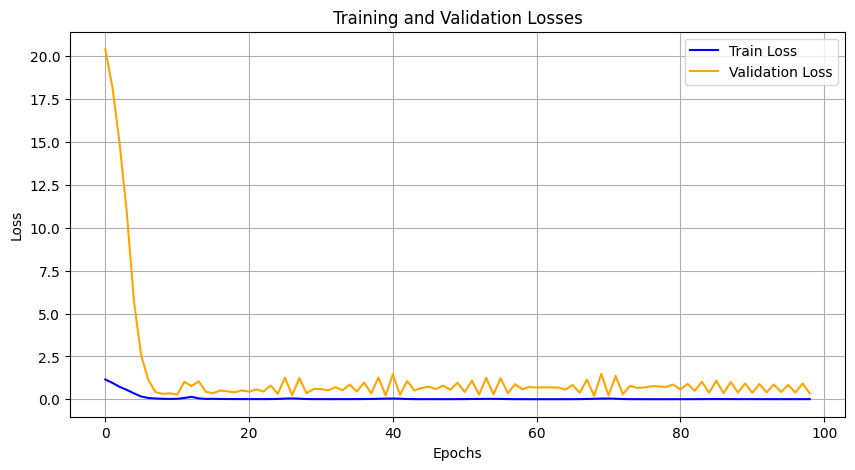

In [45]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [46]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.143831


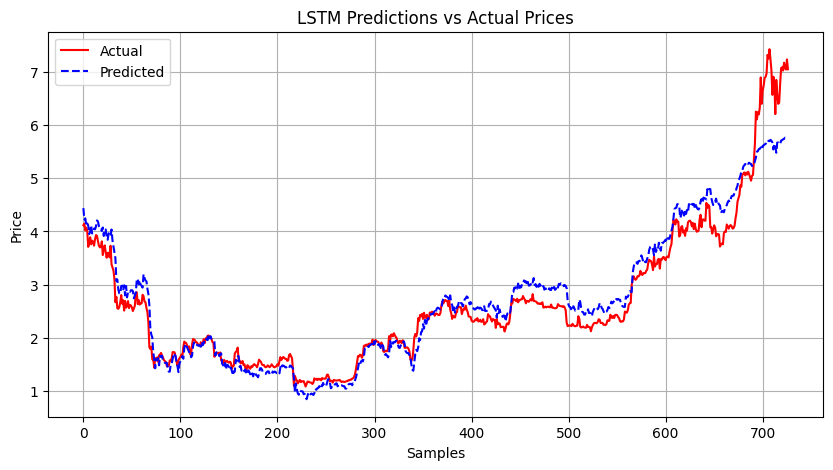

In [52]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()

In [48]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, conv_filters=96, conv_kernel=3, lstm_hidden=12, num_bilstm_layers=2, attn_heads=4, attn_dim=64, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.bilstm = nn.LSTM(input_size=conv_filters, hidden_size=lstm_hidden, num_layers=num_bilstm_layers, batch_first=True, bidirectional=True)
        # Use PyTorch MultiheadAttention: needs embedding dim. We'll map BiLSTM outputs to attn_dim
        self.proj = nn.Linear(2*lstm_hidden, attn_dim)
        self.attn = nn.MultiheadAttention(embed_dim=attn_dim, num_heads=attn_heads, batch_first=True)
        self.out_fc = nn.Sequential(
            nn.Linear(attn_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: B,T,F
        x = x.permute(0,2,1)              # B,F,T
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.permute(0,2,1)              # B,T,conv_filters
        x = self.dropout(x)
        out, _ = self.bilstm(x)           # B,T,2*lstm_hidden
        proj = self.proj(out)             # B,T,attn_dim
        # MultiheadAttention expects (B, T, E) if batch_first=True
        attn_out, _ = self.attn(proj, proj, proj)  # self-attention
        # Pool (use last time step or mean)
        pooled = attn_out.mean(dim=1)     # B, attn_dim
        out = self.out_fc(pooled)         # B,1
        return out.squeeze(-1)


In [49]:
model2 = CNN_BiLSTM_Attention(input_dim=len(features))

In [50]:
model2 = model2.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [51]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model2.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model2.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model2.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model2(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 68545
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


Epoch [1/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.97it/s]


Epoch [2/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.74it/s]


Epoch [3/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.88it/s]


Epoch [4/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.41it/s]


Epoch [5/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.06it/s]


Epoch [6/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.06it/s]


Epoch [7/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.93it/s]


Epoch [8/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.55it/s]


Epoch [9/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.20it/s]


Epoch [10/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.41it/s]


Epoch [11/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.24it/s]


Epoch [12/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.46it/s]


Epoch [13/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.23it/s]


Epoch [14/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.60it/s]


Epoch [15/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.92it/s]


Epoch [16/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 241.54it/s]


Epoch [17/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.52it/s]


Epoch [18/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 256.31it/s]


Epoch [19/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.75it/s]


Epoch [20/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.56it/s]


Epoch [21/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.92it/s]


Epoch [22/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.40it/s]


Epoch [23/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 247.85it/s]


Epoch [24/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.51it/s]


Epoch [25/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.10it/s]


Epoch [26/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.12it/s]


Epoch [27/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.40it/s]


Epoch [28/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 188.41it/s]


Epoch [29/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 227.46it/s]


Epoch [30/500] - Train Loss: 1.072887, Val Loss: 19.694732
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.46it/s]

Epoch [31/500] - Train Loss: 1.072887, Val Loss: 19.694732
Early stopping triggered after epoch 31

Best validation loss: 19.694732
